# Time series classification 

## Imports

In [1]:
import os       # using operating system dependent functionality (folders)
import pandas as pd # data analysis and manipulation
import numpy as np    # numerical computing (manipulating and performing operations on arrays of data)
import copy     # Can Copy and Deepcopy files so original file is untouched.
import matplotlib.pyplot as plt
import mne

import sys
sys.path.insert(0, '../eegyolk') # path to helper functions
import helper_functions as hf # library useful for eeg and erp data cleaning
import epod_helper
import initialization_functions

from tensorflow.keras.layers import Conv1D,BatchNormalization,LeakyReLU,MaxPool1D,\
GlobalAveragePooling1D,Dense,Dropout,AveragePooling1D
from tensorflow.keras.models import Sequential
from tensorflow.keras.backend import clear_session

from sklearn.model_selection import GroupKFold,LeaveOneGroupOut
from sklearn.preprocessing import StandardScaler

2022-10-05 12:33:14.587989: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX512F AVX512_VNNI FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2022-10-05 12:33:14.701272: I tensorflow/core/util/util.cc:169] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2022-10-05 12:33:14.730998: E tensorflow/stream_executor/cuda/cuda_blas.cc:2981] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2022-10-05 12:33:15.249059: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libnvinfer.so.7'; 

In [2]:
metadata = pd.read_csv('metadata.csv', sep = ',')

In [3]:
metadata.head()

,eeg_file,ParticipantID,test,sex,age_months,dyslexic_parent,Group_AccToParents,path_eeg,path_epoch,path_eventmarkers,epoch_file
0,105a,105,a,f,17,f,At risk,../../volume-ceph/ePodium_projectfolder/dataset,../../volume-ceph/nadine_storage/processed_epochs,../../volume-ceph/ePodium_projectfolder/events,105a_epo.fif
1,107a,107,a,f,16,m,At risk,../../volume-ceph/ePodium_projectfolder/dataset,../../volume-ceph/nadine_storage/processed_epochs,../../volume-ceph/ePodium_projectfolder/events,107a_epo.fif
2,106a,106,a,m,19,f,At risk,../../volume-ceph/ePodium_projectfolder/dataset,../../volume-ceph/nadine_storage/processed_epochs,../../volume-ceph/ePodium_projectfolder/events,106a_epo.fif
3,109a,109,a,m,21,m,At risk,../../volume-ceph/ePodium_projectfolder/dataset,../../volume-ceph/nadine_storage/processed_epochs,../../volume-ceph/ePodium_projectfolder/events,109a_epo.fif
4,110a,110,a,m,17,m,At risk,../../volume-ceph/ePodium_projectfolder/dataset,../../volume-ceph/nadine_storage/processed_epochs,../../volume-ceph/ePodium_projectfolder/events,110a_epo.fif


In [4]:
metadata['Group_AccToParents'] = np.where(
    (metadata['Group_AccToParents']=='At risk'), 1,0)

# Get input data

In [5]:
control_files= metadata.loc[metadata['Group_AccToParents'] == 0]
atrisk_files = metadata.loc[metadata['Group_AccToParents'] == 1]

In [6]:
control = initialization_functions.read_filtered_data(control_files, to_array=False)

Checking out file: 117a_epo.fif
Checking out file: 118a_epo.fif
Checking out file: 119a_epo.fif
Checking out file: 124a_epo.fif
Checking out file: 127a_epo.fif
Checking out file: 126a_epo.fif
Checking out file: 131a_epo.fif
Checking out file: 135a_epo.fif
Checking out file: 133a_epo.fif
Checking out file: 138a_epo.fif
Checking out file: 139a_epo.fif
Checking out file: 144a_epo.fif
Checking out file: 143a_epo.fif
Checking out file: 146a_epo.fif
Checking out file: 145a_epo.fif
Checking out file: 154a_epo.fif
Checking out file: 153a_epo.fif
Checking out file: 168a_epo.fif
Checking out file: 177a_epo.fif
Checking out file: 190a_epo.fif
Checking out file: 170a_epo.fif
Checking out file: 174a_epo.fif
Checking out file: 191a_epo.fif
Checking out file: 169a_epo.fif
Checking out file: 173a_epo.fif
Checking out file: 166a_epo.fif
Checking out file: 216a_epo.fif
Checking out file: 175a_epo.fif
Checking out file: 172a_epo.fif
Checking out file: 183a_epo.fif
Checking out file: 185a_epo.fif
Checking

In [7]:
atrisk = initialization_functions.read_filtered_data(atrisk_files, to_array=False)

Checking out file: 105a_epo.fif
Checking out file: 107a_epo.fif
Checking out file: 106a_epo.fif
Checking out file: 109a_epo.fif
Checking out file: 110a_epo.fif
Checking out file: 112a_epo.fif
Checking out file: 111a_epo.fif
Checking out file: 114a_epo.fif
Checking out file: 115a_epo.fif
Checking out file: 116a_epo.fif
Checking out file: 123a_epo.fif
Checking out file: 122a_epo.fif
Checking out file: 125a_epo.fif
Checking out file: 130a_epo.fif
Checking out file: 128a_epo.fif
Checking out file: 129a_epo.fif
Checking out file: 137a_epo.fif
Checking out file: 141a_epo.fif
Checking out file: 142a_epo.fif
Checking out file: 140a_epo.fif
Checking out file: 148a_epo.fif
Checking out file: 149a_epo.fif
Checking out file: 155a_epo.fif
Checking out file: 157a_epo.fif
Checking out file: 158a_epo.fif
Checking out file: 161a_epo.fif
Checking out file: 159a_epo.fif
Checking out file: 156a_epo.fif
Checking out file: 192a_epo.fif
Checking out file: 178a_epo.fif
Checking out file: 162a_epo.fif
Checking

# Data preperation for model input

Define which experiment you want to look at.

In [9]:
standard_events = ['GiepS_S'] # standards: 'GiepM_S','GiepS_S','GopM_S','GopS_S'
deviant_events = ['GiepS_D'] # deviants: 'GiepM_D','GiepS_D','GopM_D','GopS_D'

In [37]:
from mne.decoding import UnsupervisedSpatialFilter

from sklearn.decomposition import PCA, FastICA

In [43]:
def create_mmr(epoch, standard_events, deviant_events): 

    std_evoked = epoch[standard_events].average() 
    dev_evoked = epoch[deviant_events].average()
 
    # calculate the mismatch response between standard and deviant evoked
    evoked_diff = mne.combine_evoked([std_evoked, dev_evoked], weights=[1, -1]).get_data(picks=['P7', 'P3', 'Pz', 'PO3', 'O1', 'Oz', 'O2', 'PO4', 'P4', 'P8']) # mismatch for all channels per participant
    
    #pca = UnsupervisedSpatialFilter(PCA(30), average=False)
    #evoked_diff = pca.fit_transform(evoked_diff)
    return evoked_diff

def to_array(evoked_epochs):
    tot_mmr = []
    count = 0
    
    for epoch in evoked_epochs:
        mmr = create_mmr(epoch, standard_events, deviant_events)
        tot_mmr.append(mmr)
        count += 1
    print(f" loaded files: {count}")
    return tot_mmr

def input_erp(atrisk_files, control_files, atrisk, control):
    atrisk_epochs = to_array(atrisk)
    control_epochs = to_array(control)
    
    control_labels = control_files['Group_AccToParents'].tolist()
    atrisk_labels = atrisk_files['Group_AccToParents'].tolist()
    
    control_labels=[len(i)*[0] for i in control_epochs]
    atrisk_labels=[len(i)*[1] for i in atrisk_epochs]
    
    data_list = control_epochs+atrisk_epochs
    label_list = control_labels+atrisk_labels
    print(data_list[1].shape, len(data_list))
    groups_list=[[i]*len(j) for i, j in enumerate(data_list)]
   # groups_list=[i for i in range(len(data_list))]
    print(groups_list)
    data_array=np.vstack(data_list)
    label_array=np.hstack(label_list)
    group_array=np.hstack(groups_list)
   # data_array=np.moveaxis(data_array,1,2)
    
    print(data_array.shape,label_array.shape,group_array.shape) #number of segments, length, channels
    return data_array, label_array, group_array

data_array, label_array, group_array = input_erp(atrisk_files, control_files, atrisk, control)

 loaded files: 52
 loaded files: 49
(10, 2049) 101
[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0], [1, 1, 1, 1, 1, 1, 1, 1, 1, 1], [2, 2, 2, 2, 2, 2, 2, 2, 2, 2], [3, 3, 3, 3, 3, 3, 3, 3, 3, 3], [4, 4, 4, 4, 4, 4, 4, 4, 4, 4], [5, 5, 5, 5, 5, 5, 5, 5, 5, 5], [6, 6, 6, 6, 6, 6, 6, 6, 6, 6], [7, 7, 7, 7, 7, 7, 7, 7, 7, 7], [8, 8, 8, 8, 8, 8, 8, 8, 8, 8], [9, 9, 9, 9, 9, 9, 9, 9, 9, 9], [10, 10, 10, 10, 10, 10, 10, 10, 10, 10], [11, 11, 11, 11, 11, 11, 11, 11, 11, 11], [12, 12, 12, 12, 12, 12, 12, 12, 12, 12], [13, 13, 13, 13, 13, 13, 13, 13, 13, 13], [14, 14, 14, 14, 14, 14, 14, 14, 14, 14], [15, 15, 15, 15, 15, 15, 15, 15, 15, 15], [16, 16, 16, 16, 16, 16, 16, 16, 16, 16], [17, 17, 17, 17, 17, 17, 17, 17, 17, 17], [18, 18, 18, 18, 18, 18, 18, 18, 18, 18], [19, 19, 19, 19, 19, 19, 19, 19, 19, 19], [20, 20, 20, 20, 20, 20, 20, 20, 20, 20], [21, 21, 21, 21, 21, 21, 21, 21, 21, 21], [22, 22, 22, 22, 22, 22, 22, 22, 22, 22], [23, 23, 23, 23, 23, 23, 23, 23, 23, 23], [24, 24, 24, 24, 24, 24, 24, 24, 24, 24]

# Convolutional Neural Network

In [65]:
def cnnmodel():
    clear_session()
    model=Sequential()
    model.add(Conv1D(filters=4,kernel_size=3,strides=1,input_shape=(2049,1)))#1
    model.add(BatchNormalization())
    model.add(LeakyReLU())
    model.add(MaxPool1D(pool_size=2,strides=2))#2
    model.add(Conv1D(filters=5,kernel_size=3,strides=1))#3
    model.add(LeakyReLU())
    model.add(MaxPool1D(pool_size=2,strides=2))#4
    model.add(Dropout(0.5))
    #model.add(Conv1D(filters=5,kernel_size=3,strides=1))#5
    #model.add(LeakyReLU())
    #model.add(AveragePooling1D(pool_size=2,strides=2))#6
    #model.add(Dropout(0.5))
    #model.add(Conv1D(filters=5,kernel_size=3,strides=1))#7
    #model.add(LeakyReLU())
    #model.add(AveragePooling1D(pool_size=2,strides=2))#8
    #model.add(Conv1D(filters=5,kernel_size=3,strides=1))#9
    #model.add(LeakyReLU())
    model.add(GlobalAveragePooling1D())#10
    model.add(Dense(1,activation='relu'))#11
    
    model.compile('adam',loss='binary_crossentropy',metrics=['accuracy'])
    return model

model=cnnmodel()
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv1d (Conv1D)             (None, 2047, 4)           16        
                                                                 
 batch_normalization (BatchN  (None, 2047, 4)          16        
 ormalization)                                                   
                                                                 
 leaky_re_lu (LeakyReLU)     (None, 2047, 4)           0         
                                                                 
 max_pooling1d (MaxPooling1D  (None, 1023, 4)          0         
 )                                                               
                                                                 
 conv1d_1 (Conv1D)           (None, 1021, 5)           65        
                                                                 
 leaky_re_lu_1 (LeakyReLU)   (None, 1021, 5)           0

In [66]:
gkf=GroupKFold(n_splits=3)

In [67]:
group_array

array([  0,   0,   0, ..., 100, 100, 100])

In [68]:
## reduce dimensions

Epoch 1/1000
21/21 [==============================] - 1s 17ms/step - loss: 4.6247 - accuracy: 0.4940 - val_loss: 1.0394 - val_accuracy: 0.4824
Epoch 2/1000
21/21 [==============================] - 0s 10ms/step - loss: 2.6926 - accuracy: 0.4940 - val_loss: 0.9941 - val_accuracy: 0.4824
Epoch 3/1000
21/21 [==============================] - 0s 11ms/step - loss: 2.1676 - accuracy: 0.4925 - val_loss: 0.9811 - val_accuracy: 0.4824
Epoch 4/1000
21/21 [==============================] - 0s 10ms/step - loss: 1.9993 - accuracy: 0.4925 - val_loss: 0.9729 - val_accuracy: 0.4853
Epoch 5/1000
21/21 [==============================] - 0s 10ms/step - loss: 1.3669 - accuracy: 0.4925 - val_loss: 0.9707 - val_accuracy: 0.4824
Epoch 6/1000
21/21 [==============================] - 0s 11ms/step - loss: 1.0992 - accuracy: 0.4910 - val_loss: 0.9641 - val_accuracy: 0.4853
Epoch 7/1000
21/21 [==============================] - 0s 10ms/step - loss: 1.0007 - accuracy: 0.4925 - val_loss: 0.9569 - val_accuracy: 0.4853

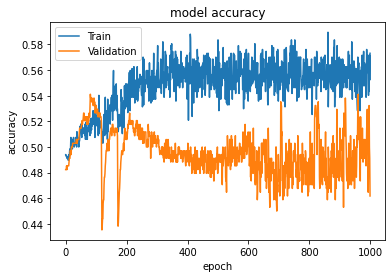

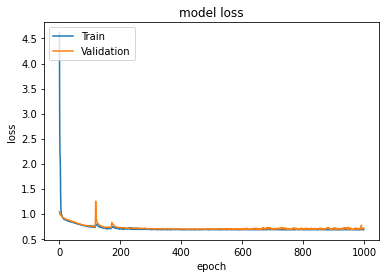

Epoch 1/1000
21/21 [==============================] - 1s 18ms/step - loss: 5.6073 - accuracy: 0.4821 - val_loss: 5.6131 - val_accuracy: 0.5088
Epoch 2/1000
21/21 [==============================] - 0s 12ms/step - loss: 5.0764 - accuracy: 0.4821 - val_loss: 5.1314 - val_accuracy: 0.5118
Epoch 3/1000
21/21 [==============================] - 0s 14ms/step - loss: 4.8874 - accuracy: 0.4821 - val_loss: 4.8176 - val_accuracy: 0.5118
Epoch 4/1000
21/21 [==============================] - 0s 12ms/step - loss: 4.6582 - accuracy: 0.4836 - val_loss: 4.4989 - val_accuracy: 0.5118
Epoch 5/1000
21/21 [==============================] - 0s 11ms/step - loss: 4.3822 - accuracy: 0.4866 - val_loss: 4.2776 - val_accuracy: 0.5118
Epoch 6/1000
21/21 [==============================] - 0s 11ms/step - loss: 4.0578 - accuracy: 0.4836 - val_loss: 3.6645 - val_accuracy: 0.5118
Epoch 7/1000
21/21 [==============================] - 0s 11ms/step - loss: 3.6708 - accuracy: 0.4776 - val_loss: 3.2732 - val_accuracy: 0.5118

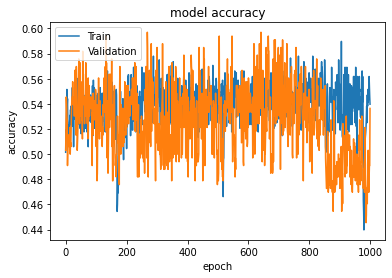

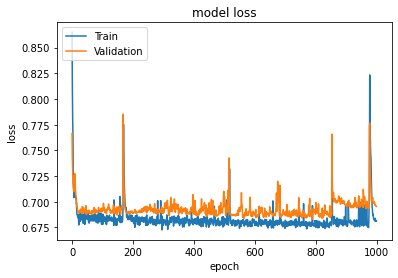

In [71]:
val_accuracy=[]
val_loss=[]
train_accuracy=[]
train_loss=[]
for train_index, val_index in gkf.split(data_array, label_array, groups=group_array):
    train_features,train_labels=data_array[train_index],label_array[train_index]
    val_features,val_labels=data_array[val_index],label_array[val_index]
    scaler=StandardScaler()
    train_features = scaler.fit_transform(train_features.reshape(-1, train_features.shape[-1])).reshape(train_features.shape)
    val_features = scaler.transform(val_features.reshape(-1, val_features.shape[-1])).reshape(val_features.shape)
    model=cnnmodel()
    history = model.fit(train_features,train_labels,epochs=1000,batch_size=32,validation_data=(val_features,val_labels))
    val_accuracy.append(model.evaluate(val_features,val_labels)[1])
    
    
    # summarize history for accuracy
    plt.plot(history.history['accuracy'])
    plt.plot(history.history['val_accuracy'])
    plt.title('model accuracy')
    plt.ylabel('accuracy')
    plt.xlabel('epoch')
    plt.legend(['Train', 'Validation'], loc='upper left')
    plt.show()
    # summarize history for loss
    plt.plot(history.history['loss'])
    plt.plot(history.history['val_loss'])
    plt.title('model loss')
    plt.ylabel('loss')
    plt.xlabel('epoch')
    plt.legend(['Train', 'Validation'], loc='upper left')
    plt.show()

In [73]:
acc = np.mean(val_accuracy)
acc

0.49741533398628235

# Recurrent Neural Network

In [30]:
import numpy as np
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, LSTM

In [31]:
from keras.optimizers import SGD
from keras import optimizers



In [34]:
def rnnmodel():
    model = Sequential()
    #model.add(LSTM(128,  input_shape=(2049,32),activation='relu', return_sequences=True))

    model.add(layers.SimpleRNN(64, input_shape=(2049,10)))
    model.add(layers.BatchNormalization())
    model.add(layers.Dense(10))

    optimizer = optimizers.Adam(clipvalue=0.5)
    model.compile(optimizer=optimizer, loss="mse", metrics=["accuracy"])
    return model
 
model=rnnmodel()
model.summary()

Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 simple_rnn_2 (SimpleRNN)    (None, 64)                4800      
                                                                 
 batch_normalization_2 (Batc  (None, 64)               256       
 hNormalization)                                                 
                                                                 
 dense_3 (Dense)             (None, 10)                650       
                                                                 
Total params: 5,706
Trainable params: 5,578
Non-trainable params: 128
_________________________________________________________________


In [35]:
val_accuracy=[]
val_loss=[]
train_accuracy=[]
train_loss=[]
for train_index, val_index in gkf.split(data_array, label_array, groups=group_array):
    train_features,train_labels=data_array[train_index],label_array[train_index]
    val_features,val_labels=data_array[val_index],label_array[val_index]
    scaler=StandardScaler()
    train_features = scaler.fit_transform(train_features.reshape(-1, train_features.shape[-1])).reshape(train_features.shape)
    val_features = scaler.transform(val_features.reshape(-1, val_features.shape[-1])).reshape(val_features.shape)
    model=rnnmodel()
    history = model.fit(train_features,train_labels,epochs=50,batch_size=16,validation_data=(val_features,val_labels))
    val_accuracy.append(model.evaluate(val_features,val_labels)[1])

[ 0  1  2  4  5  7  8 10 11 13 14 16 17 19 20 23 24 26 28 29 31 32 34 35
 36 38 40 41 43 44 46 47 48 49 50 51 52 53 55 56 58 59 61 62 64 65 67 68
 70 71 74 75 77 79 80 82 83 85 86 87 89 91 92 94 95 97 98]
Epoch 1/50
5/5 [==============================] - 2s 291ms/step - loss: 2.9010 - accuracy: 0.0448 - val_loss: 0.9546 - val_accuracy: 0.0882
Epoch 2/50
5/5 [==============================] - 1s 255ms/step - loss: 1.7246 - accuracy: 0.0746 - val_loss: 0.8129 - val_accuracy: 0.0588
Epoch 3/50
5/5 [==============================] - 1s 255ms/step - loss: 1.2865 - accuracy: 0.0746 - val_loss: 0.7510 - val_accuracy: 0.1176
Epoch 4/50
5/5 [==============================] - 1s 274ms/step - loss: 0.9976 - accuracy: 0.1045 - val_loss: 0.7132 - val_accuracy: 0.0882
Epoch 5/50
5/5 [==============================] - 1s 261ms/step - loss: 0.8445 - accuracy: 0.0896 - val_loss: 0.6937 - val_accuracy: 0.0588
Epoch 6/50
5/5 [==============================] - 1s 260ms/step - loss: 0.7380 - accuracy: 0.13

In [92]:
# Binary Classification with Sonar Dataset: Standardized
from pandas import read_csv
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from scikeras.wrappers import KerasClassifier
from sklearn.model_selection import cross_val_score
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import StratifiedKFold
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline

encoder = LabelEncoder()
encoder.fit(label_array)
encoded_Y = encoder.transform(label_array)


def create_baseline():
    # create model
    model = Sequential()
    model.add(Dense(60, input_shape=(2049,32), activation='relu'))
    model.add(Dense(1, activation='sigmoid'))
    # Compile model
    model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
    return model
# evaluate baseline model with standardized dataset
data_array = scaler.fit_transform(data_array.reshape(-1, data_array.shape[-1])).reshape(data_array.shape)
estimators = []
estimators.append(('standardize', StandardScaler()))
estimators.append(('mlp', KerasClassifier(model=create_baseline, epochs=100, batch_size=5, verbose=0)))
pipeline = Pipeline(estimators)
kfold = StratifiedKFold(n_splits=10, shuffle=True)
results = cross_val_score(pipeline, data_array, encoded_Y, cv=kfold,error_score='raise')
print("Standardized: %.2f%% (%.2f%%)" % (results.mean()*100, results.std()*100))

ValueError: Found array with dim 3. StandardScaler expected <= 2.

In [86]:
pip install scikeras

Note: you may need to restart the kernel to use updated packages.
